In [196]:
#
text = "'life is beautiful if you understand it, life is a song with a beautiful tune'\n--Farid El-Atrash"
#print(text.upper().translate(str.maketrans({ 'O':'0', 'I':'1','F':'2','E':'3','A':'4','S':'5','G':'6','T':'7', 'B':'8','P':'9'})))

In [201]:
region = 'US'

In [202]:
#/usr/bin/python3.8
# Use jupyter notebook with python 3+
"""
Auth : Al Sabawi
Date: Mar 14, 2020
Last Update : Mar 21, 2020
"""
# Need the following libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from scipy.signal import argrelextrema
import warnings
warnings.filterwarnings("ignore")
from IPython.display import Markdown as md
from IPython.display import display, HTML

## Some Helper Functions
import io
import requests

display(md('<font size=6><strong>{}</strong></font><br/>'.format(region)))
def FindLocalMinMax(df, colname, n):
    # Find local peaks
    df['min'] = df.iloc[argrelextrema(df[colname].values,
                                      np.less_equal,
                                      order=n)[0]][colname]
    df['max'] = df.iloc[argrelextrema(df[colname].values,
                                      np.greater_equal,
                                      order=n)[0]][colname]

    return df

def GetCSVFromURL(filename):
    base = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/'
    url = base+filename
    s=requests.get(url).content
    c=pd.read_csv(url,encoding = 'utf-8')
    return c


<font size=6><strong>US</strong></font><br/>

In [203]:
## Download the latest data file from:
## https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_time_series
## File name "time_series_19-covid-Confirmed.csv"  for all confirmed cases in the world by region
## *** DOWNLOAD to local directory ***
confirmed_filename = 'time_series_covid19_confirmed_global.csv'
recovered_filename = 'time_series_covid19_recovered_global.csv'
deaths_filename = 'time_series_covid19_deaths_global.csv'

## If you are reading from files downloaded to local directory, uncomment the lines below
#df_confirmed = pd.read_csv(confirmed_filename)
#df_recovered = pd.read_csv(recovered_filename)
#df_deaths = pd.read_csv(deaths_filename)

## If the following 3 lines of code are no longer commented out, then
## you DON'T NEED to download the 3 files to local directory. 
df_confirmed = GetCSVFromURL(confirmed_filename)
df_recovered = GetCSVFromURL(recovered_filename)
df_deaths = GetCSVFromURL(deaths_filename)

## Separate the dates to use as an index later
dates = df_confirmed.columns[4:]
dates_recovered = df_recovered.columns[4:]

## Filter for a specific region data only
usa = df_confirmed[df_confirmed['Country/Region'].values == region].copy(
    deep=True)
usa_recovered = df_recovered[df_recovered['Country/Region'].values ==
                             region].copy(deep=True)
usa_deaths = df_deaths[df_deaths['Country/Region'].values == region].copy(
    deep=True)

usad = usa[dates].copy(deep=True)
last_date = usa[dates].columns[-1]

## Put the US data into a DataFrame Series and give it a name
colname = 'Confirmed ' + region + ' COVID-19 Cases'
colname_recovered = 'Recovered in ' + region + ' from COVID-19 Cases'
colname_deaths = 'Deaths in ' + region + ' from COVID-19 Cases'

us_df_cumulative = pd.DataFrame(usa[dates].sum(), columns=[colname])
us_df_cumulative['dates'] = dates
us_df_recovered_cum = pd.DataFrame(usa_recovered[dates_recovered].sum(),
                                   columns=[colname_recovered])
us_df_deaths_cum = pd.DataFrame(usa_deaths[dates].sum(),
                                columns=[colname_deaths])



Daily New Confirmed cases Peaked at 496,535  cases on Apr 10, 2020 
The Peak daily New Cases was 35,098


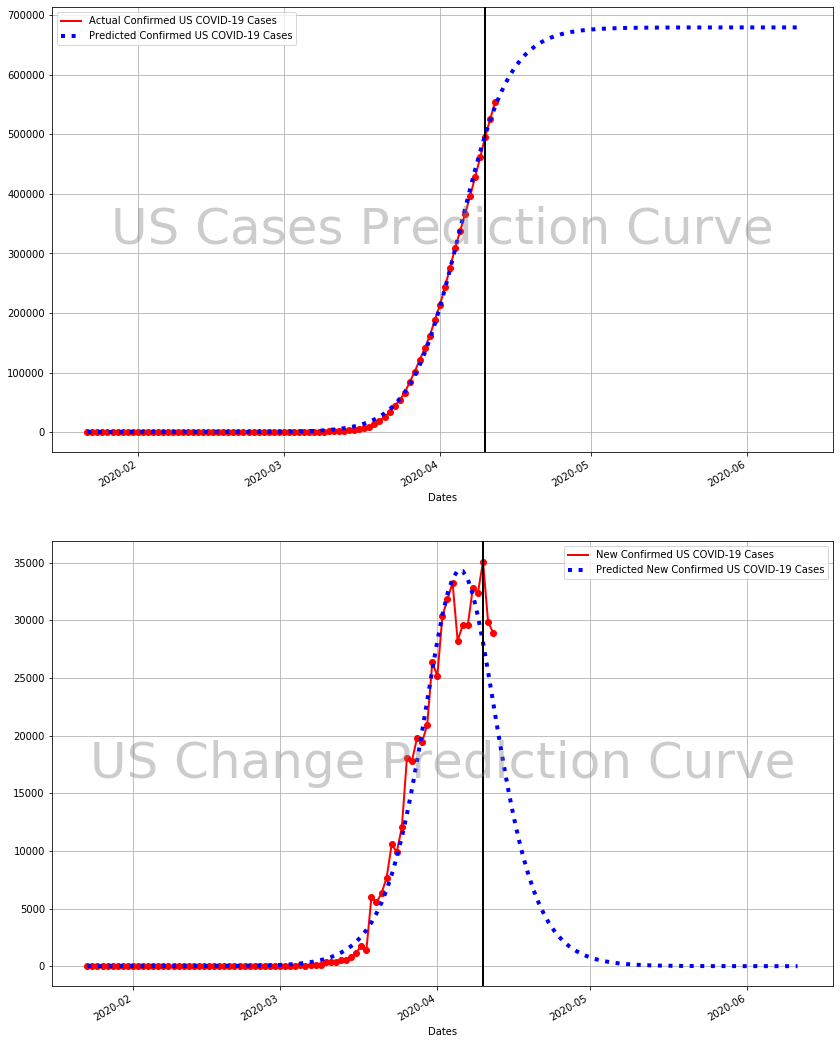

In [231]:
# good discussion here:  http://stackoverflow.com/questions/4308168/sigmoidal-regression-with-scipy-numpy-python-etc
# curve_fit() example from here: http://permalink.gmane.org/gmane.comp.python.scientific.user/26238
# other sigmoid functions here: http://en.wikipedia.org/wiki/Sigmoid_function

import numpy as np
import datetime
from scipy.optimize import curve_fit

def sigmoid2(x, x0, k , a):
     y = a / (1 + np.exp(-k*(x-x0)))
     return y

actual_days_count = us_df_cumulative.shape[0]
predict_days = 60
total_days_tofit = actual_days_count + predict_days

base = datetime.datetime.strptime(dates[0], '%m/%d/%y')
date_list = [base + datetime.timedelta(days=d) for d in range(total_days_tofit)]

xdata = np.arange(0,actual_days_count)
ydata = np.array(us_df_cumulative[colname].values.tolist())

popt, pcov = curve_fit(sigmoid2, xdata, ydata)
##############print('Logistic Param : ',popt)


x = np.linspace(-1, total_days_tofit , total_days_tofit)
y = sigmoid2(x, *popt)

pred_df = pd.DataFrame()
pred_df['Dates'] = date_list

actcol = 'Actual '+colname
deltacol = 'New '+colname

tmp_df = pd.DataFrame({actcol: us_df_cumulative[colname].values.tolist()})
pred_df = pd.concat([pred_df, tmp_df], axis=1) 

pred_df[deltacol] = pred_df[actcol].diff(1)

predcol = 'Predicted ' + colname
pred_df[predcol] = sigmoid2(x, *popt)

preddeltacol = 'Predicted New '+colname
pred_df[preddeltacol] = pred_df[predcol].diff(1)

pred_df.set_index('Dates',inplace=True)

diffmax = pred_df[actcol].diff(1).max()
diffmax_date =pred_df[actcol].diff(1).idxmax(axis=1)
peack_at = int(round(pred_df[pred_df[actcol].index == diffmax_date][actcol],0))
print("Daily New Confirmed cases Peaked at", 
      f'{peack_at:,}' ," cases", 
      'on '+ (diffmax_date.strftime("%b %d, %Y") ),
      "\nThe Peak daily New Cases was", 
      f'{int(diffmax):,}') 

fig, ax = plt.subplots(2,1,figsize=(14,20))

ax[0].plot(pred_df[actcol], 'o', c='red', lw=8)
pred_df[actcol].plot(ax=ax[0],color='red',lw=2)
ax[0].axvline(diffmax_date, lw=2, c='black')


style=[':']
pred_df[predcol].plot(ax=ax[0],style=style,color='blue',lw=4)


ax[0].text(0.5,
           0.5,
           region + ' Cases Prediction Curve',
           horizontalalignment='center',
           color='gray',
           fontsize=50,
           alpha=0.4,
           verticalalignment='center',
           transform=ax[0].transAxes)


ax[0].legend(loc='best')
ax[0].grid(True)

ax[1].plot(pred_df[deltacol], 'o', c='red', lw=8)
pred_df[deltacol].plot(ax=ax[1],color='red',lw=2)

pred_df[preddeltacol].plot(ax=ax[1],style=style,color='blue',lw=4)
ax[1].axvline(diffmax_date, lw=2, c='black')



ax[1].text(0.5,
           0.5,
           region + ' Change Prediction Curve',
           horizontalalignment='center',
           color='gray',
           fontsize=50,
           alpha=0.4,
           verticalalignment='center',
           transform=ax[1].transAxes)


ax[1].legend(loc='best')
ax[1].grid(True)
plt.show()